In [1]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")



In [2]:
sales = pd.read_csv('sales_train.csv')
items = pd.read_csv('items.csv')
item_cat = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')
test = pd.read_csv('test.csv')

In [3]:
#formating the dates properly.
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


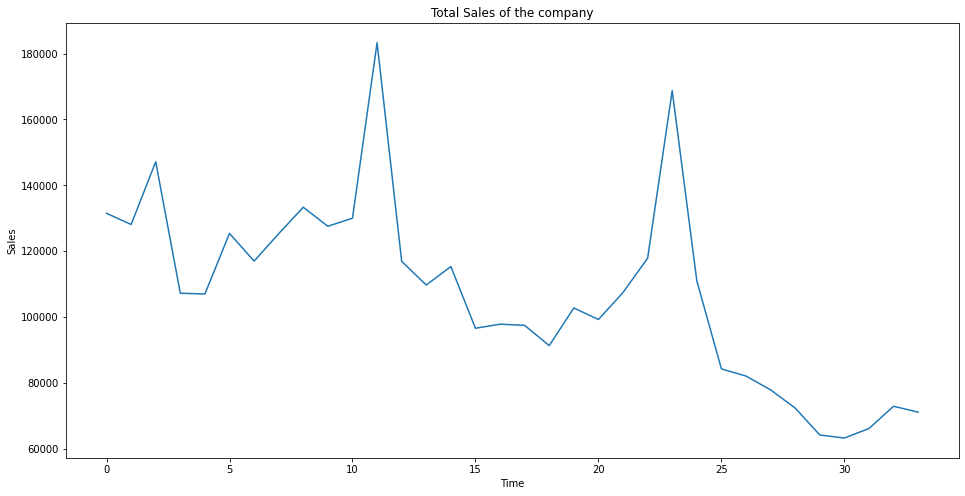

In [4]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

In [5]:
from statsmodels.tsa.stattools import adfuller
def rolling(time):
    rolmean = time.rolling(window = 12, center = False).mean()
    rolstd = time.rolling(window = 12, center = False).std()
    
    plt.figure(figsize = (10,10))
    plt.plot(time)
    plt.plot(rolmean,'b', label = 'Rolling Mean')
    plt.plot(rolstd, 'r', label = 'ROlling STD')
    plt.legend()
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(time, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


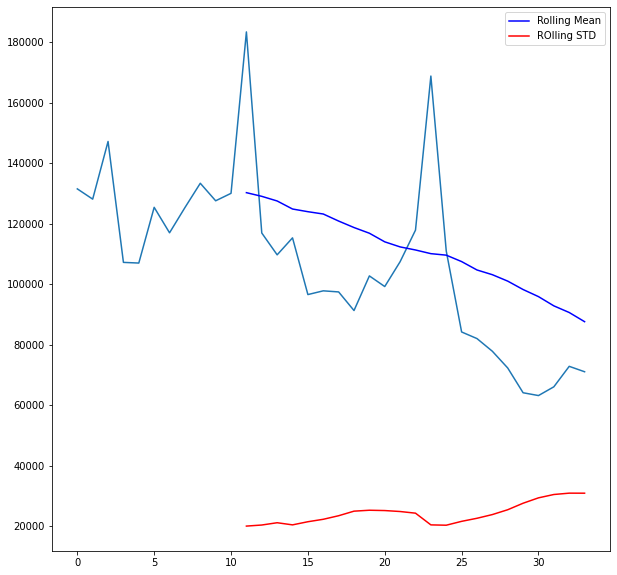

In [6]:
rolling(ts)

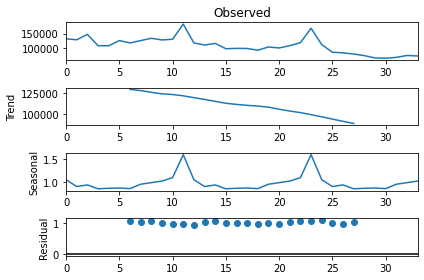

In [7]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

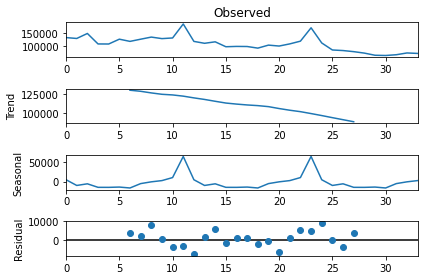

In [8]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

In [9]:
#let's remove the trend.
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

[]

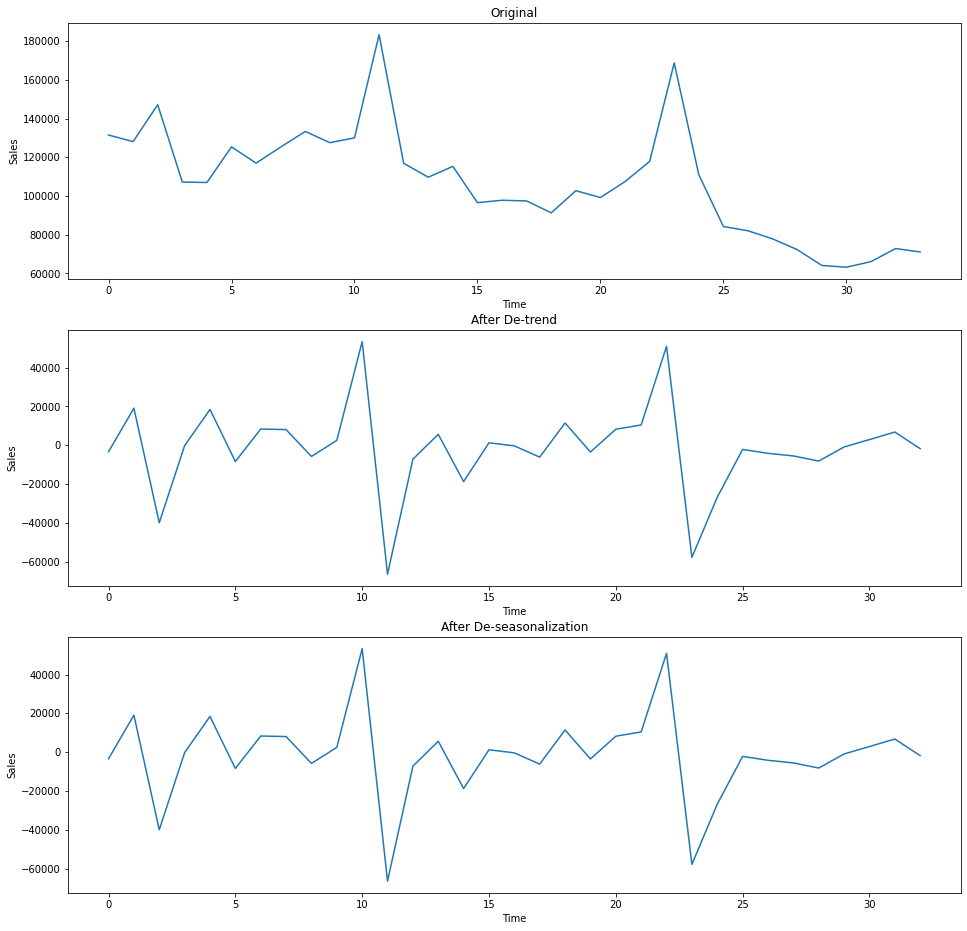

In [10]:
s=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts1=difference(ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


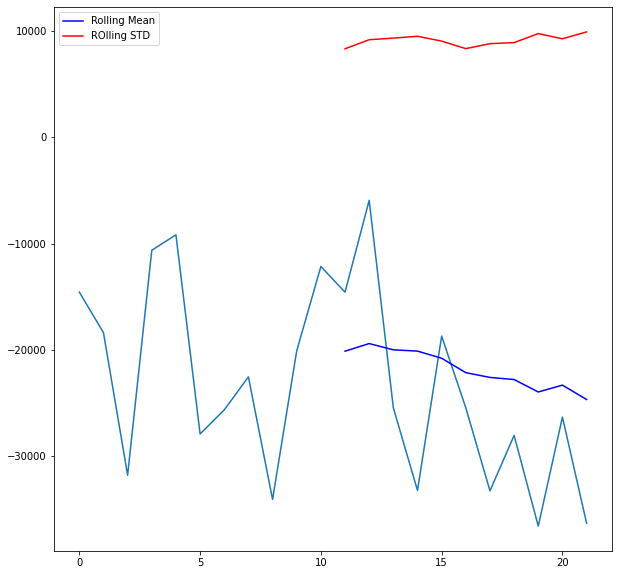

In [11]:
rolling(new_ts1)

As the p-value of our new time-series is about 1%(which is well below the customary 5% mark), we can assume that we've made the series stationary.

> Let's start with the ARIMA models.

In [35]:
train = ts[:-12]
test = ts[-12:]

In [36]:
train.shape, test.shape

((22,), (12,))

In [37]:
from pmdarima import auto_arima 
  
# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 
  
# Fit auto_arima function to AirPassengers dataset 
stepwise_fit = auto_arima(train, start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=217.062, Time=0.45 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=212.368, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=215.976, Time=0.07 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=215.463, Time=0.08 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=231.843, Time=0.02 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=214.326, Time=0.07 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=214.337, Time=0.04 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=214.370, Time=0.03 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=213.688, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=215.852, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 1.290 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   22
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -104.184
Date:                  Tue, 11 Aug 2020   AIC                            212.368
Time:                          12:58:49   BIC                            212.974
Sample:                               0   HQIC                           211.704
                                   - 22                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.151e+04   2561.381     -8.398      0.000   -2.65e+04   -1.65e+04
sigma2      6.559e+07   4.58e+07      1.431      0.152   -2.43e+07    1.55e+08
===================================================================================
Ljung-Box (Q):                        7.42   Jarque-Bera (JB):                 0.58
Prob(Q):                              0.59   Prob(JB):                         0.75
Heteroskedasticity (H):               0.99   Skew:                             0.01
Prob(H) (two-sided):                  0.99   Kurtosis:                         1.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 

model = SARIMAX(new_ts1,  
                order = (0, 0, 0),  
                seasonal_order =(0, 1, 0, 12)) 
  
result = model.fit() 
result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   22
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -106.381
Date:                  Tue, 11 Aug 2020   AIC                            214.761
Time:                          12:59:22   BIC                            215.064
Sample:                               0   HQIC                           214.429
                                   - 22                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      9.524e+07   5.92e+07      1.609      0.108   -2.08e+07    2.11e+08
===================================================================================
Ljung-Box (Q):                       19.55   Jarque-Bera (JB):                 0.59
Prob(Q):                              0.02   Prob(JB):                         0.74
Heteroskedasticity (H):               4.11   Skew:                             0.33
Prob(H) (two-sided):                  0.28   Kurtosis:                         2.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date_block_num'>

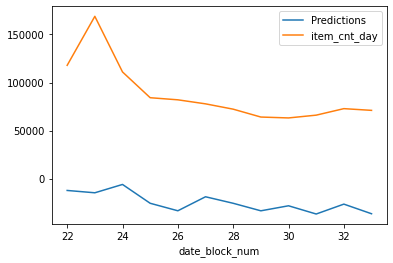

In [39]:
start = len(train) 
end = len(train) + len(test) - 1

# Predictions for one-year against the test set 
predictions = result.predict(start, end, 
							typ = 'levels').rename("Predictions") 

# plot predictions and actual values 
predictions.plot(legend = True) 
test.plot(legend = True) 


In [29]:
from sklearn.metrics import mean_squared_error 
from statsmodels.tools.eval_measures import rmse 
  
# Calculate root mean squared error 
rmse(test, predictions) 
  
# Calculate mean squared error 
np.sqrt(mean_squared_error(test, predictions) )

114800.67954575298

0    -14580.0
1    -18403.0
2    -31845.0
3    -10634.0
4     -9180.0
5    -27952.0
6    -25686.0
7    -22570.0
8    -34124.0
9    -20119.0
10   -12164.0
11   -14587.0
12    -5928.0
13   -25489.0
14   -33283.0
15   -18729.0
16   -25495.0
17   -33315.0
18   -28093.0
19   -36642.0
20   -26365.0
21   -36366.0
dtype: float64

<AxesSubplot:>

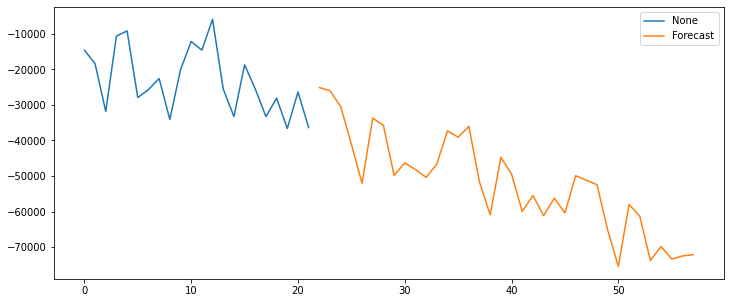

In [41]:
# Train the model on the full dataset 
model = model = SARIMAX(new_ts1, 
						order = (0, 1, 1), 
						seasonal_order =(2, 1, 1, 12)) 
result = model.fit() 

# Forecast for the next 3 years 
forecast = result.predict(start = len(new_ts1), 
						end = (len(new_ts1)-1) + 3 * 12, 
						typ = 'levels').rename('Forecast') 

# Plot the forecast values 
new_ts1.plot(figsize = (12, 5), legend = True) 
forecast.plot(legend = True) 
